In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
X_train, y_train = pd.read_pickle('./data/pickle/preproc/df_patient_admit_icu__20210126_TRAIN_final.pkl')

# SAMEDAY ICU

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from customTransformers import ColumnSelectTransformer, DiagnosisFrameTransformer, EstimatorTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [8]:
cols = ['GENDER','ADMISSION_TYPE','ADMISSION_LOCATION','INSURANCE','LANGUAGE',
       'RELIGION','MARITAL_STATUS','ETHNICITY','ADMIT_AGE']

demog_feats = FeatureUnion([
    ('stdscl', ColumnTransformer([('numerical', StandardScaler(), ['ADMIT_AGE'])])),
    ('ohe',  ColumnTransformer([('categorical', OneHotEncoder(handle_unknown='ignore'), cols)]))
])
demog_pipe = Pipeline([
    ('features', demog_feats),
    ('reg', LogisticRegression(solver='liblinear'))
])
demog_params = {
    'reg__penalty': ['l1','l2','none'],
    'reg__C': [0.01, 0.1, 1, 10],
    'reg__class_weight': ['none','balanced'],
}

# lin_gs_regressor = GridSearchCV(demog_pipe, demog_params, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=3,n_jobs=-1)
# lin_est = lin_gs_regressor.fit(X_train,X_train['SAMEDAY_ADM_TO_ICU'])

In [11]:
lin_est.best_params_,lin_est.best_score_

({'reg__C': 0.1, 'reg__class_weight': 'balanced', 'reg__penalty': 'l2'},
 0.5722280875294657)

In [5]:
diagn_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count',CountVectorizer(max_features=3000)),
    ('tfid', TfidfTransformer()),
    ('rfc', RandomForestClassifier())
])

diagn_params = {
    'rfc__criterion': ['gini','entropy'],
    'rfc__max_features': ['auto', 'sqrt', 'log2'],
    'rfc__min_samples_split': [2,5,8,11],
    'rfc__min_samples_leaf': [1,4,7],
    'rfc__class_weight': ['balanced', 'balanced_subsample'],
}

diagn_gs_regressor = GridSearchCV(diagn_pipe, diagn_params, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=3,n_jobs=10)
tfidf_est = diagn_gs_regressor.fit(X_train,X_train['SAMEDAY_ADM_TO_ICU'])

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   49.6s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:  6.3min
[Parallel(n_jobs=10)]: Done 492 tasks      | elapsed: 11.8min
/Users/adamgifford/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=10)]: Done 720 out of 720 | elapsed: 16.5min finished


In [6]:
tfidf_est.best_params_,tfidf_est.best_score_

({'rfc__class_weight': 'balanced_subsample',
  'rfc__criterion': 'entropy',
  'rfc__max_features': 'log2',
  'rfc__min_samples_leaf': 1,
  'rfc__min_samples_split': 2},
 0.7360997577172081)

In [9]:
demog_est = LogisticRegression(solver='liblinear', C=0.1, class_weight='balanced', penalty='l2')
demog_pipe = Pipeline([
    ('features', demog_feats),
    ('reg', demog_est)
])

diagn_est = RandomForestClassifier(class_weight='balanced_subsample',criterion='entropy',
                                  max_features='log2',min_samples_leaf=1,
                                  min_samples_split=2)
diagn_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count',CountVectorizer(max_features=3000)),
    ('tfid', TfidfTransformer()),
    ('rfc', diagn_est)
])

union = FeatureUnion([
    ('demog', EstimatorTransformer(demog_pipe)),# FeatureUnions use the same syntax as Pipelines
    ('diagn',EstimatorTransformer(diagn_pipe))
])


full_pipe = Pipeline([
    ('union',union),
    ('xgb', GradientBoostingClassifier())
])

xgb_params = {
    'xgb__loss': ['deviance','exponential'],
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'xgb__subsample': [0.8, 1, 1.2], # max is 1
    'xgb__criterion': ['mse','friedman_mse'],
    'xgb__min_samples_leaf': [1,4,7],
    'xgb__max_depth': [2,3,4,5],
    'xgb__max_features': ['auto','log2',None]
}

xgb_gs_classifier = GridSearchCV(full_pipe, xgb_params, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=3,n_jobs=12)
xgb_est = xgb_gs_classifier.fit(X_train,X_train['SAMEDAY_ADM_TO_ICU'])

xgb_est.best_params_,xgb_est.best_score_

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:   53.8s
/Users/adamgifford/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed: 52.7min
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed: 554.2min
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed: 576.0min
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed: 602.4min
[Parallel(n_jobs=12)]: Done 1544 tasks      | elapsed: 640.9min
[Parallel(n_jobs=12)]: Done 2024 tasks      | elapsed: 682.8min
[Parallel(n_jobs=12)]: Done 2568 tasks      | elapsed: 730.6min
[Parallel(n_jobs=12)]: Done 3176 tasks      | elapsed: 784.4min
[Parallel(n_jobs=12)]: Don

({'xgb__criterion': 'mse',
  'xgb__learning_rate': 0.05,
  'xgb__loss': 'exponential',
  'xgb__max_depth': 4,
  'xgb__max_features': 'auto',
  'xgb__min_samples_leaf': 4,
  'xgb__subsample': 0.8},
 0.761460606507654)

In [11]:
X_test, y_test = pd.read_pickle('./data/pickle/preproc/df_patient_admit_icu__20210126_TEST_final.pkl')

In [50]:
y_pred = xgb_est.predict(X_test)
print(confusion_matrix(X_test['SAMEDAY_ADM_TO_ICU'],y_pred))
print(accuracy_score(X_test['SAMEDAY_ADM_TO_ICU'],y_pred))
print(f1_score(X_test['SAMEDAY_ADM_TO_ICU'],y_pred))

[[1163 1659]
 [1306 8066]]
0.7568476299819583
0.844740011520134


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.86')

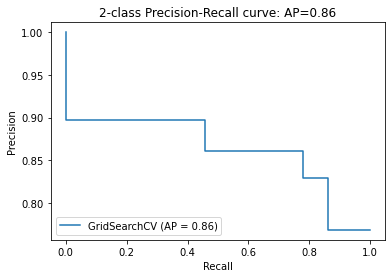

In [18]:
y_score = xgb_est.decision_function(X_test)
average_precision = average_precision_score(X_test['SAMEDAY_ADM_TO_ICU'], y_score)

disp = plot_precision_recall_curve(xgb_est, X_test, X_test['SAMEDAY_ADM_TO_ICU'])
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [21]:
file = './data/pickle/models/log_rf_xgb__SAMEDAY__20210127.pkl'
pickle.dump((demog_pipe, diagn_pipe, xgb_est),open(file,'wb'))

In [103]:
y_pred = xgb_est.predict(X_test)

corr_sum = sum((y_pred==1) & (y_pred==X_test['SAMEDAY_ADM_TO_ICU']))
incorr_sum = sum((y_pred==0) & (y_pred!=X_test['SAMEDAY_ADM_TO_ICU'])
total = corr_sum+incorr_sum

correct=np.mean(days_adm_icu[(y_pred==1) & (y_pred==X_test['SAMEDAY_ADM_TO_ICU'])])*24
incorrect=np.mean(days_adm_icu[(y_pred==0) & (y_pred!=X_test['SAMEDAY_ADM_TO_ICU'])])*24

hours_saved = (corr_sum/total)*correct - (incorr_sum/total)*incorrect
minutes_saved = hours_saved*60
minutes_saved

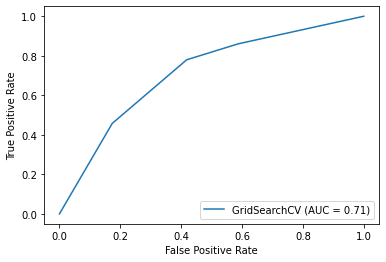

In [106]:
plot_roc_curve(xgb_est, X_test, X_test['SAMEDAY_ADM_TO_ICU'])

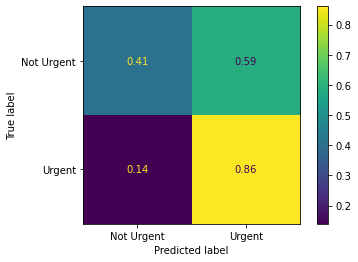

In [114]:
plot_confusion_matrix(xgb_est, X_test, X_test['SAMEDAY_ADM_TO_ICU'],display_labels=['Not Urgent', 'Urgent'],normalize='true')

# ICU URGENCY SCORE

In [ ]:
## TRYING TO IMPLEMENT 4 OVR CLASSIFICATION SYSTEMS FOR ICU_URGENCY.
# 1. CREATE AND TUNE OVR for demographics
# 2. use multinomial classifier for diagnoses
# 3. use all 5 outputs as features in a second multinomial to pool results
from sklearn.preprocessing import OrdinalEncoder

cols = ['GENDER','ADMISSION_TYPE','ADMISSION_LOCATION','INSURANCE','LANGUAGE',
       'RELIGION','MARITAL_STATUS','ETHNICITY','ADMIT_AGE']

demog_feats1 = FeatureUnion([
    ('stdscl', ColumnTransformer([('numerical', StandardScaler(), ['ADMIT_AGE'])])),
    ('ohe',  ColumnTransformer([('categorical', OneHotEncoder(handle_unknown='ignore'), cols)]))
])

demog_pipe1 = Pipeline([
    ('features', demog_feats),
    ('reg', LogisticRegression(solver='saga'))
])
demog_params1 = {
    'reg__penalty': ['l1','l2','none'],
    'reg__C': [0.01, 0.1, 1, 10],
    'reg__class_weight': ['none','balanced'],
    'reg__multi_class': ['ovr','multinomial'],
}

ordenc = OrdinalEncoder(categories=[['stable','questionable','urgent','immediate']])
y_train_enc = ordenc.fit_transform(y_train.to_numpy().reshape(-1,1))
lin_gs_classifier1 = GridSearchCV(demog_pipe1, demog_params1, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=3,n_jobs=4)
lin_est1 = lin_gs_classifier1.fit(X_train,y_train_enc)
lin_est1.best_params_,lin_est.best_score_

In [ ]:
diagn_pipe1 = Pipeline([
    ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count',CountVectorizer(max_features=3000)),
    ('tfid', TfidfTransformer()),
    ('rfc', RandomForestClassifier())
])

diagn_params1 = {
    'rfc__criterion': ['gini','entropy'],
    'rfc__max_features': ['auto', 'sqrt', 'log2'],
    'rfc__min_samples_split': [2,5,8,11],
    'rfc__min_samples_leaf': [1,4,7],
    'rfc__class_weight': ['balanced', 'balanced_subsample'],
}

diagn_gs_classifier1 = GridSearchCV(diagn_pipe1, diagn_params1, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=3,n_jobs=4)
tfidf_est1 = diagn_gs_classifier1.fit(X_train,y_train_enc)
tfidf_est1.best_params_,tfidf_est1.best_score_

In [ ]:


demog_est1 = LogisticRegression(solver='saga', C=0.1, class_weight='none', 
                               penalty='l2', multi_class='ovr')
demog_pipe1 = Pipeline([
    ('features', demog_feats),
    ('reg', demog_est1)
])

diagn_est1 = RandomForestClassifier(class_weight='balanced',criterion='gini',
                                  max_features='sqrt',min_samples_leaf=1,
                                  min_samples_split=2)
diagn_pipe1 = Pipeline([
    ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count',CountVectorizer(max_features=3000)),
    ('tfid', TfidfTransformer()),
    ('rfc', diagn_est1)
])

union1 = FeatureUnion([
    ('demog', EstimatorTransformer(demog_pipe1)),# FeatureUnions use the same syntax as Pipelines
    ('diagn',EstimatorTransformer(diagn_pipe1))
])


full_pipe1 = Pipeline([
    ('union',union1),
    ('xgb', GradientBoostingClassifier())
])

xgb_params1 = {
    'xgb__loss': ['deviance','exponential'],
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'xgb__subsample': [0.8, 1], # max is 1
    'xgb__criterion': ['friedman_mse'],
    'xgb__min_samples_leaf': [1, 4, 7],
    'xgb__max_depth': [2,3,4],
    'xgb__max_features': ['auto']
}

xgb_gs_classifier1 = GridSearchCV(full_pipe1, xgb_params1, cv=StratifiedKFold(n_splits=3, shuffle=True),verbose=3,n_jobs=4)
xgb_est1 = xgb_gs_classifier1.fit(X_train,y_train_enc)

xgb_est1.best_params_,xgb_est1.best_score_

In [ ]:
y_test_enc = ordenc.transform(y_test.to_numpy().reshape(-1,1))
y_pred = xgb_est1.predict(X_test)
print(confusion_matrix(y_test_enc,y_pred))
print(accuracy_score(y_test_enc,y_pred))
print(f1_score(y_test_enc,y_pred, average='weighted'))

In [ ]:
file = './data/pickle/models/log_rf_xgb__URGENCY__20210127.pkl'
pickle.dump((demog_pipe1, diagn_pipe1, xgb_est1),open(file,'wb'))

# Length of stay

In [116]:
cols = ['GENDER','ADMISSION_TYPE','ADMISSION_LOCATION','INSURANCE','LANGUAGE',
       'RELIGION','MARITAL_STATUS','ETHNICITY','ADMIT_AGE']

demog_feats2 = FeatureUnion([
    ('stdscl', ColumnTransformer([('numerical', StandardScaler(), ['ADMIT_AGE'])])),
    ('ohe',  ColumnTransformer([('categorical', OneHotEncoder(handle_unknown='ignore'), cols)]))
])
demog_pipe2 = Pipeline([
    ('features', demog_feats),
    ('ridge', Ridge())
])
demog_params2 = {
    'ridge__alpha': (0.01, 0.1, 1, 10, 100),
    'ridge__normalize': ('uniform', 'distance'),
    'ridge__fit_intercept': (True, False)
}
lin_gs_regressor2 = GridSearchCV(demog_pipe2, demog_params2, cv=KFold(n_splits=5, shuffle=True),verbose=3,n_jobs=-1)
lin_est2 = lin_gs_regressor2.fit(X_train,X_train['DAYS_ADM_TO_ICU'])
lin_est2.best_params_,lin_est2.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished


({'ridge__alpha': 100,
  'ridge__fit_intercept': False,
  'ridge__normalize': 'uniform'},
 0.022632554083947865)

In [119]:
diagn_pipe2 = Pipeline([
    ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count',CountVectorizer(max_features=3000)),
    ('tfid', TfidfTransformer()),
    ('rfr', RandomForestRegressor())
])

diagn_params2 = {
    'rfr__criterion': ['mse','mae'],
    'rfr__max_features': ['auto', 'sqrt', 'log2'],
    'rfr__min_samples_split': [2,5,8,11],
    'rfr__min_samples_leaf': [1,4,7],
    'rfr__ccp_alpha': [0,0.5,1,2]
}

diagn_gs_classifier2 = GridSearchCV(diagn_pipe2, diagn_params2, cv=KFold(n_splits=5, shuffle=True),verbose=3,n_jobs=14)
tfidf_est2 = diagn_gs_classifier2.fit(X_train,X_train['DAYS_ADM_TO_ICU'])
tfidf_est2.best_params_,tfidf_est2.best_score_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:  6.0min


KeyboardInterrupt: 